# 9. Testing the model

In [1]:
import time
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import copy

In [2]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [3]:
from keras.applications.xception import Xception, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from nltk.util import ngrams
from keras import optimizers

In [4]:
# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

C:\Users\admin\Anaconda3\envs\imagecap2\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


C:\Users\admin\Anaconda3\envs\imagecap2\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [5]:
# Set these path according to project folder in you system
dataset_text = "C:\\Users\\smita\\Desktop\\Aegis School of Data Science\\Capstone Project Folder\\Flickr8k_text"
dataset_images = "C:\\Users\\smita\\Desktop\\Aegis School of Data Science\\Capstone Project Folder\\Flickr8k_Dataset\\Flicker8k_Dataset"

In [6]:
filename1 = dataset_text + "\\" + "Flickr_8k.testImages.txt"

In [7]:
def history_data(directory):
    acc = []
    loss = []
    #val_acc=[]
    #val_loss=[]
    for i in os.listdir(directory):
        history=load(open(directory + "/" + i, 'rb'))
        acc.append(history['accuracy'])
        loss.append(history['loss'])
    return acc, loss

In [8]:
directory_xception = "C:\\Users\\admin\\aegis\\Capstone_project\\streamlit\\project\\history_p1_xception_0.001"
directory_inceptionV3 = "C:\\Users\\admin\\aegis\\Capstone_project\\streamlit\\project\\history_p1_inceptionV3_0.001"
directory_mobilenet = "C:\\Users\\admin\\aegis\\Capstone_project\\streamlit\\project\\history_p1_mobilenet_0.001"
directory_resnet50 = "C:\\Users\\admin\\aegis\\Capstone_project\\streamlit\\project\\history_p1_resnet50_0.001"
#directory_vgg16 = "C:\\Users\\admin\\aegis\\Capstone_project\\streamlit\\project\\history_p1_vgg16"

In [9]:
acc_xception, loss_xception = history_data(directory_xception)
acc_inceptionV3, loss_inceptionV3 = history_data(directory_inceptionV3)
acc_mobilenet, loss_mobilenet = history_data(directory_mobilenet)
acc_resnet50, loss_resnet50 = history_data(directory_resnet50)
acc_vgg16, loss_vgg16 = history_data(directory_vgg16)

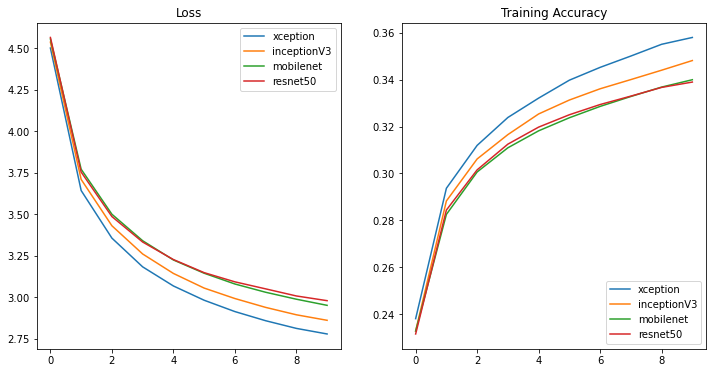

In [60]:
epochs = 10
epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)

plt.plot(epochs_range, acc_xception, label='xception')
plt.plot(epochs_range, acc_inceptionV3, label='inceptionV3')
plt.plot(epochs_range, acc_mobilenet, label='mobilenet')
plt.plot(epochs_range, acc_resnet50, label='resnet50')
#plt.plot(epochs_range, acc_vgg16, label='vgg16')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss_xception, label='xception')
plt.plot(epochs_range, loss_inceptionV3, label='inceptionV3')
plt.plot(epochs_range, loss_mobilenet, label='mobilenet')
plt.plot(epochs_range, loss_resnet50, label='resnet50')
#plt.plot(epochs_range, loss_vgg16, label='vgg16')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

# Test generating

In [11]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [12]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos

In [13]:
test_imgs = load_photos(filename1)

In [14]:
len(test_imgs)

1000

In [15]:
def load_features(photos,features_app):
    #loading all features
    all_features = load(open(features_app,"rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

In [16]:
features_xception = "features_p1_xception.p"
features_inceptionV3 = "features_p1_inceptionV3.p"
features_mobilenet = "features_p1_mobilenet.p"
features_resnet50 = "features_p1_resnet50.p"
#features_vgg16 = "features_p1_vgg16.p"

In [17]:
test_features_xception = load_features(test_imgs, features_xception)
test_features_inceptionV3 = load_features(test_imgs, features_inceptionV3)
test_features_mobilenet = load_features(test_imgs, features_mobilenet)
test_features_resnet50 = load_features(test_imgs, features_resnet50)
#test_features_vgg16 = load_features(test_imgs, features_vgg16)

In [18]:
def extract_features_test(filename, model_2, shape, preprocess_input):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize(shape)
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        #image = image/127.5
        #image = image - 1.0
        feature = model_2.predict(image)
        return feature

In [19]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
            return None

In [27]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startcap'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endcap':
            break
            
    final_caption = in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [24]:
max_length = 34
tokenizer = load(open("tokenizer_project1.p","rb"))
model_xception = load_model('models_p1_xception_0.001/model_9.h5')
model_inceptionV3 = load_model('models_p1_inceptionV3_0.001/model_9.h5')
model_mobilenet = load_model('models_p1_mobilenet_0.001/model_9.h5')
model_resnet50 = load_model('models_p1_resnet50_0.001/model_9.h5')
#model_vgg16 = load_model('models_p1_vgg16/model_9.h5')
model_2_xception = Xception(include_top=False, pooling="avg")
model_1_inceptionV3 = InceptionV3( weights = 'imagenet' )
model_2_inceptionV3 = Model(model_1_inceptionV3.input, model_1_inceptionV3.layers[-2].output)
model_2_mobilenet = MobileNet(weights = 'imagenet', include_top=False, pooling='avg')
model_1_resnet50 = ResNet50( weights='imagenet', input_shape=(224,224,3))
model_2_resnet50 = Model(model_1_resnet50.input, model_1_resnet50.layers[-2].output)
#model_1_vgg16 = VGG16( weights = 'imagenet' )
#model_2_vgg16 = Model(model_1_vgg16.input, model_1_vgg16.layers[-2].output)
preprocess_input_xception = keras.applications.xception.preprocess_input
preprocess_input_inceptionV3 = keras.applications.inception_v3.preprocess_input
preprocess_input_resnet50 = keras.applications.resnet50.preprocess_input
preprocess_input_mobilenet = keras.applications.mobilenet.preprocess_input
preprocess_input_vgg16 = keras.applications.vgg16.preprocess_input
shape_xception = (299,299)
shape_inceptionV3 = (299,299)
shape_resnet50 = (224,224)
shape_mobilenet = (224,224)
#shape_vgg16 = (224,224)
dataset = dataset_images

C:\Users\admin\Anaconda3\envs\imagecap2\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\admin\Anaconda3\envs\imagecap2\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\admin\Anaconda3\envs\imagecap2\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\admin\Anaconda3\envs\imagecap2\lib\site-packages\tensorflo

In [25]:
def test_caption(n, filename, model, model_2, shape, preprocess_input):
    for i in range(n):
        rn = np.random.randint(1,len(test_imgs))
        img_name = test_imgs[rn]
        #img_name = list(test_features.keys())[rn]
        #photo = test_features[img_name].reshape((1,2048))
        photo = extract_features_test(filename+'/'+img_name, model_2, shape, preprocess_input)
        i = plt.imread(dataset_images+'/'+img_name)
        plt.imshow(i)
        plt.axis('off')
        plt.show()
    
        caption = generate_desc(model, tokenizer, photo, max_length)
        print(caption)

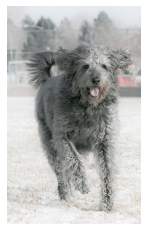

dog is running through the grass


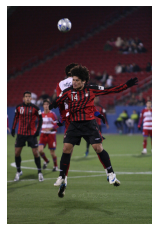

two men playing soccer on field


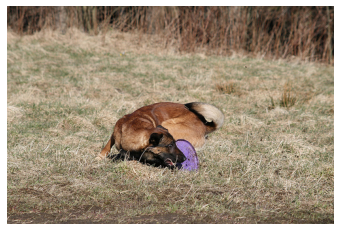

two dogs are playing in the grass


In [28]:
test_caption(3, dataset_images, model_xception, model_2_xception, shape_xception, preprocess_input_xception)

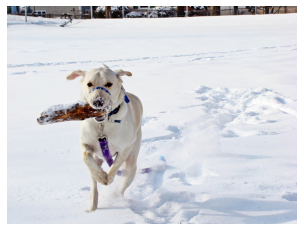

white dog is running through the snow


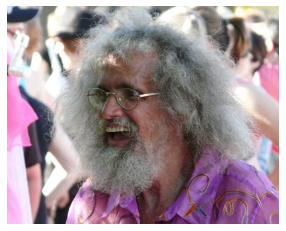

two girls are sitting on the floor


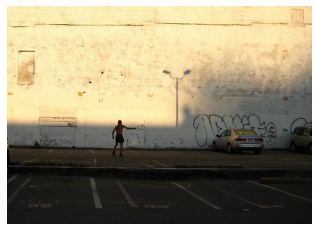

man in red shirt is standing on the street


In [29]:
test_caption(3, dataset_images, model_resnet50, model_2_resnet50, shape_resnet50, preprocess_input_resnet50)

# Sentence bleu score

In [ ]:
""" Calculate BLEU score (Bilingual Evaluation Understudy) from Papineni, 
Kishore, Salim Roukos, Todd Ward, and Wei-Jing Zhu. 2002.
    BLEU: a method for automatic evaluation of machine translation."""

In [30]:
def load_clean_descriptions_test(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            #desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(image_caption)
    return descriptions

In [31]:
test_descriptions = load_clean_descriptions_test("descriptions_project1.txt", test_imgs)

In [32]:
test_descriptions

{'1056338697_4f7d7ce270.jpg': [['blond',
   'woman',
   'in',
   'blue',
   'shirt',
   'appears',
   'to',
   'wait',
   'for',
   'ride'],
  ['blond', 'woman', 'is', 'on', 'the', 'street', 'hailing', 'taxi'],
  ['woman',
   'is',
   'signaling',
   'is',
   'to',
   'traffic',
   'as',
   'seen',
   'from',
   'behind'],
  ['woman',
   'with',
   'blonde',
   'hair',
   'wearing',
   'blue',
   'tube',
   'top',
   'is',
   'waving',
   'on',
   'the',
   'side',
   'of',
   'the',
   'street'],
  ['the',
   'woman',
   'in',
   'the',
   'blue',
   'dress',
   'is',
   'holding',
   'out',
   'her',
   'arm',
   'at',
   'oncoming',
   'traffic']],
 '106490881_5a2dd9b7bd.jpg': [['boy',
   'in',
   'his',
   'blue',
   'swim',
   'shorts',
   'at',
   'the',
   'beach'],
  ['boy', 'smiles', 'for', 'the', 'camera', 'at', 'beach'],
  ['young',
   'boy',
   'in',
   'swimming',
   'trunks',
   'is',
   'walking',
   'with',
   'his',
   'arms',
   'outstretched',
   'on',
   'the',
   '

In [33]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [34]:
tokenizer_test = create_tokenizer(test_descriptions)
dump(tokenizer_test, open('tokenizer_test_project1.p', 'wb'))
vocab_size = len(tokenizer_test.word_index) + 1
vocab_size

3177

In [35]:
test_desc = dict_to_list(test_descriptions)

In [36]:
test_texts=tokenizer_test.texts_to_sequences(test_desc)

In [37]:
test_feat = dict_to_list(test_features_vgg16)

In [38]:
#from nltk.translate.bleu_score import sentence_bleu
index_word = dict([(index,word) for word, index in tokenizer_test.word_index.items()])

In [39]:
tokenizer_test_dict={}
for key, desc in test_descriptions.items():
    tokenizer_test_dict[key]=tokenizer_test.texts_to_sequences(desc)

In [46]:
def bleu_caption(n,model, filename,model_2, shape, preprocess_input, max_length):
    for i in range(n):
        #caption_trues, captions = [], []  
        rn = np.random.randint(1,len(test_imgs))
        img_name = test_imgs[rn]
        #img_name = list(test_features.keys())[rn]
        #photo = test_features[img_name].reshape((1,2048))
    
        photo = extract_features_test(filename+'/'+img_name, model_2, shape, preprocess_input)
        im = plt.imread(filename+'/'+img_name)
        plt.imshow(im)
        plt.axis('off')
        plt.show()
        captions_true = []
        captions = []
        sentence_bleus=[]
        sentence_bleus1=[]
        sentence_bleus2=[]
        sentence_bleus3=[]
        sentence_bleus4=[]
        for k in range(5):
            #caption_trues, captions = [], []
            test_descriptions
            caption_true = test_descriptions[img_name][k]
            #caption_true = [ index_word[i] for i in tokenizer_test_dict[img_name][k] ]
            #caption_true = caption_true[1:-1]
            caption = generate_desc(model, tokenizer, photo, max_length)
            #caption = caption[1:-1]
            #bleu = float(sentence_bleu([caption_true],caption))
            #bleu = float(corpus_bleu([[caption_true]],[caption]))
            #caption_trues = '\n'.join(caption_true)
            captions_true.append(caption_true)
            caption = caption.split(' ') 
            #caption_trues = '\n'.join(caption_trues)
            captions.append(list(caption))
            """ To avoid harsh behaviour when no ngram overlaps are found a smoothing
        function can be used """
            smooth = SmoothingFunction()
            sentence_bleu0 = sentence_bleu([caption_true],caption,smoothing_function=smooth.method7)
            sentence_bleus.append(sentence_bleu0)
        
        
        bleu_sent1 = sentence_bleu(captions_true,caption,weights=(1.0,0,0,0), smoothing_function=smooth.method7)
        bleu_sent2 = sentence_bleu(captions_true,caption,weights=(0.5,0.5,0,0), smoothing_function=smooth.method7)
        bleu_sent3 = sentence_bleu(captions_true,caption,weights=(0.3,0.3,0.3,0), smoothing_function=smooth.method7)
        bleu_sent4 = sentence_bleu(captions_true,caption,weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth.method7)
        
      
        #bleu_corp = corpus_bleu(captions_true,captions,weights=(0.25, 0.25, 0.25, 0.25))
            #bleus.append(bleu)
    
        print('True captions: ',captions_true)
        print('Predict caption: ',caption)
        print('sentence_bleus ',sentence_bleus)
        print('bleu_sent1 ',bleu_sent1)
        print('bleu_sent2 ',bleu_sent2)
        print('bleu_sent3 ',bleu_sent3)
        print('bleu_sent4 ',bleu_sent4)
    

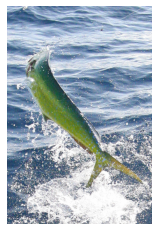

True captions:  [['green', 'fish', 'is', 'jumping', 'out', 'of', 'water'], ['large', 'fish', 'breaching', 'the', 'water', 'surface'], ['large', 'green', 'and', 'blue', 'fish', 'leaps', 'from', 'the', 'water'], ['large', 'green', 'fish', 'jumps', 'out', 'of', 'the', 'water'], ['the', 'large', 'green', 'fish', 'is', 'jumping', 'out', 'of', 'the', 'water']]
Predict caption:  ['two', 'people', 'are', 'sitting', 'on', 'the', 'edge', 'of', 'the', 'beach', 'looking', 'at', 'the', 'camera']
sentence_bleus  [0.3508906111895028, 0.3508906111895028, 0.3508906111895028, 0.3316211901136854, 0.3464874957715648]
bleu_sent1  0.5018315018315018
bleu_sent2  0.3887189896089398
bleu_sent3  0.4164237453778041
bleu_sent4  0.3464874957715648


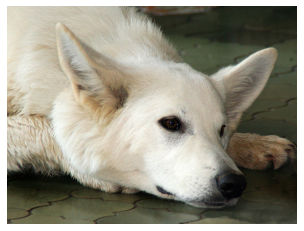

True captions:  [['closeup', 'of', 'white', 'dog', 'that', 'is', 'laying', 'its', 'head', 'on', 'its', 'paws'], ['large', 'white', 'dog', 'lying', 'on', 'the', 'floor'], ['white', 'dog', 'has', 'its', 'head', 'on', 'the', 'ground'], ['white', 'dog', 'is', 'resting', 'its', 'head', 'on', 'tiled', 'floor', 'with', 'its', 'eyes', 'open'], ['white', 'dog', 'rests', 'its', 'head', 'on', 'the', 'patio', 'bricks']]
Predict caption:  ['dog', 'is', 'running', 'through', 'the', 'grass']
sentence_bleus  [0.3766548215722228, 0.8666736636262233, 0.7336234177035934, 0.2700658322003234, 0.6209988160378852]
bleu_sent1  0.6207532649197836
bleu_sent2  0.6109371078198129
bleu_sent3  0.7494540766199331
bleu_sent4  0.7778366501457997


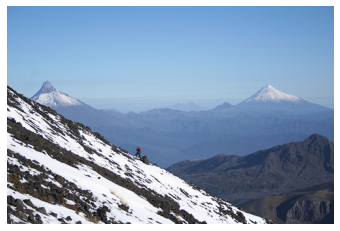

True captions:  [['man', 'is', 'climbing', 'the', 'mountain'], ['mountain', 'climber', 'is', 'seen', 'on', 'the', 'side', 'of', 'tall', 'mountain'], ['solitary', 'climber', 'on', 'snowy', 'high', 'mountains'], ['snow', 'covered', 'mountains', 'with', 'person', 'walking', 'up', 'in', 'the', 'background'], ['the', 'mountaintop', 'is', 'filled', 'with', 'snow']]
Predict caption:  ['man', 'is', 'standing', 'on', 'top', 'of', 'rock', 'overlooking', 'the', 'mountains']
sentence_bleus  [0.483303919870482, 0.5639258685525019, 0.519347857819894, 0.519347857819894, 0.519347857819894]
bleu_sent1  0.7703703703703704
bleu_sent2  0.6002123397882104
bleu_sent3  0.6238766242725875
bleu_sent4  0.5491336068659544


In [47]:
bleu_caption(3,model_inceptionV3, dataset_images,model_2_inceptionV3, shape_inceptionV3, preprocess_input_inceptionV3, max_length)

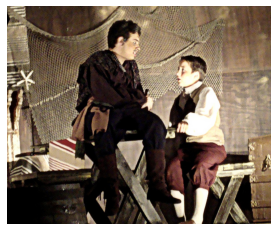

True captions:  [['man', 'talks', 'to', 'boy'], ['an', 'older', 'man', 'is', 'speaking', 'to', 'boy', 'while', 'both', 'are', 'sitting'], ['two', 'boys', 'talking', 'while', 'wearing', 'unique', 'outfits'], ['two', 'males', 'in', 'period', 'costume', 'are', 'having', 'conversation'], ['two', 'people', 'sitting', 'on', 'benches', 'and', 'looking', 'at', 'each', 'other']]
Predict caption:  ['man', 'in', 'red', 'shirt', 'and', 'blue', 'hat', 'is', 'standing', 'in', 'front', 'of', 'store']
sentence_bleus  [0.37675070614617184, 0.39324342339551327, 0, 0.37675070614617184, 0.37675070614617184]
bleu_sent1  0.6203881003019941
bleu_sent2  0.5033552774378662
bleu_sent3  0.510909759852316
bleu_sent4  0.4247314795805353


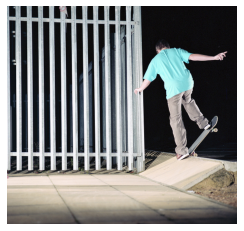

True captions:  [['boy', 'wearing', 'teal', 'shirt', 'is', 'riding', 'skateboard', 'on', 'sidewalk'], ['man', 'wearing', 'green', 'shirt', 'is', 'skateboarding', 'on', 'ramp', 'beside', 'white', 'fence'], ['skateboarder', 'in', 'light', 'green', 'shirt'], ['young', 'male', 'wearing', 'blue', 'shirt', 'rides', 'skateboard', 'in', 'an', 'outdoor', 'park', 'at', 'night'], ['young', 'man', 'skateboards', 'at', 'night', 'by', 'fence']]
Predict caption:  ['man', 'in', 'red', 'shirt', 'and', 'blue', 'jeans', 'is', 'standing', 'on', 'the', 'street']
sentence_bleus  [0.444179980604877, 0.46139728276189684, 0.426429696296719, 0.40866531024567826, 0.4080458798204693]
bleu_sent1  0.7579438794517946
bleu_sent2  0.6016993275593797
bleu_sent3  0.5910415786924297
bleu_sent4  0.4945257296995148


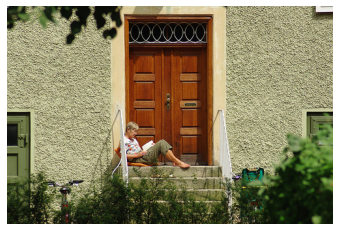

True captions:  [['lady', 'sitting', 'on', 'front', 'porch', 'reading', 'book'], ['person', 'sits', 'at', 'doorstep', 'and', 'reads', 'book'], ['woman', 'is', 'reading', 'literature', 'and', 'sitting', 'on', 'the', 'front', 'stoop', 'of', 'building'], ['woman', 'sits', 'and', 'reads', 'in', 'the', 'stoop', 'of', 'wooden', 'door'], ['woman', 'sits', 'and', 'reads', 'on', 'the', 'front', 'stoop', 'of', 'her', 'building']]
Predict caption:  ['two', 'girls', 'are', 'playing', 'in', 'the', 'street']
sentence_bleus  [0, 0, 0.3789189653572099, 0.4554397570529575, 0.43710765433794935]
bleu_sent1  0.5793650793650794
bleu_sent2  0.5661876977961803
bleu_sent3  0.7006975763634228
bleu_sent4  0.6991287239961747


In [48]:
bleu_caption(3,model_mobilenet, dataset_images,model_2_mobilenet, shape_mobilenet, preprocess_input_mobilenet, max_length)

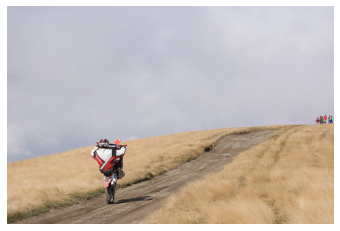

True captions:  [['man', 'doing', 'wheelie', 'on', 'motorcycle'], ['motorcyclist', 'is', 'pulling', 'wheelie', 'on', 'motocross', 'bike', 'as', 'he', 'rides', 'it', 'up', 'dirt', 'track'], ['motorcyclist', 'wearing', 'red', 'and', 'white', 'jacket', 'popping', 'wheelie', 'on', 'his', 'motorcycle'], ['person', 'popping', 'wheelie', 'on', 'dirt', 'road'], ['the', 'man', 'is', 'walking', 'towards', 'group', 'of', 'people', 'on', 'long', 'dirt', 'road']]
Predict caption:  ['man', 'in', 'red', 'shirt', 'is', 'riding', 'bike', 'on', 'the', 'mountain']
sentence_bleus  [0.519347857819894, 0.3633366662135622, 0.4699253747322595, 0.49569881208754957, 0.46170345104014493]
bleu_sent1  0.7698313993892955
bleu_sent2  0.6328030405954885
bleu_sent3  0.6300137305814739
bleu_sent4  0.5481443874361138


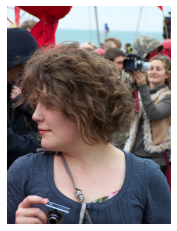

True captions:  [['lady', 'looks', 'to', 'her', 'right', 'and', 'holds', 'mini', 'camera'], ['lady', 'with', 'curly', 'brown', 'hair', 'stands', 'in', 'crowd', 'with', 'camera'], ['woman', 'holding', 'camera'], ['woman', 'stands', 'in', 'crowd', 'holding', 'camera'], ['the', 'woman', 'with', 'camera', 'is', 'looking', 'to', 'the', 'side', 'in', 'crowded', 'area']]
Predict caption:  ['man', 'in', 'white', 'shirt', 'and', 'white', 'shirt', 'is', 'sitting', 'on', 'the', 'floor']
sentence_bleus  [0.4080458798204693, 0.4080458798204693, 0, 0.4080458798204693, 0.444179980604877]
bleu_sent1  0.6468327683406835
bleu_sent2  0.5338647731702489
bleu_sent3  0.5458132701385097
bleu_sent4  0.46139728276189684


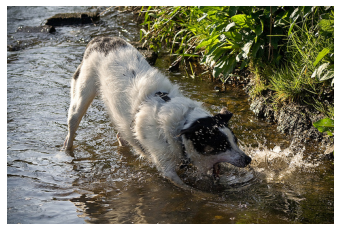

True captions:  [['black', 'and', 'white', 'dog', 'is', 'playing', 'in', 'pond', 'or', 'creek'], ['black', 'and', 'white', 'dog', 'is', 'splashing', 'around', 'in', 'the', 'water'], ['black', 'and', 'white', 'dog', 'is', 'splashing', 'in', 'stream'], ['dog', 'playing', 'in', 'some', 'water'], ['white', 'dog', 'is', 'splashing', 'in', 'an', 'outdoor', 'stream', 'next', 'to', 'grassy', 'bank']]
Predict caption:  ['white', 'dog', 'is', 'running', 'through', 'the', 'water']
sentence_bleus  [0.3998748158197829, 0.4717400543170162, 0.5321182948633977, 0.813698631703254, 0.300496844161229]
bleu_sent1  0.8462379497561298
bleu_sent2  0.6402156280527427
bleu_sent3  0.6540951454127606
bleu_sent4  0.627750244304129


In [49]:
bleu_caption(3,model_resnet50, dataset_images,model_2_resnet50, shape_resnet50, preprocess_input_resnet50, max_length)

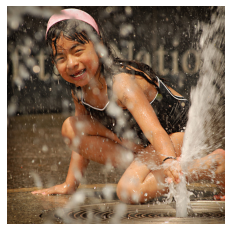

True captions:  [['girl', 'with', 'black', 'swimsuit', 'plays', 'in', 'the', 'sprinkler'], ['young', 'girl', 'is', 'playing', 'in', 'fountain', 'of', 'water'], ['young', 'girl', 'plays', 'in', 'fountain', 'water'], ['little', 'girl', 'crouches', 'to', 'splash', 'fountain', 'water'], ['there', 'is', 'young', 'girl', 'in', 'bathing', 'suit', 'playing', 'with', 'water', 'shooting', 'out', 'of', 'the', 'ground']]
Predict caption:  ['two', 'children', 'are', 'playing', 'in', 'water', 'fountain']
sentence_bleus  [0.6709877912364987, 0.6738003021622665, 0.8512426745830155, 0.813698631703254, 0.27146687079851833]
bleu_sent1  0.7698412698412699
bleu_sent2  0.6890861386535692
bleu_sent3  0.7935597767399802
bleu_sent4  0.7772724421241369


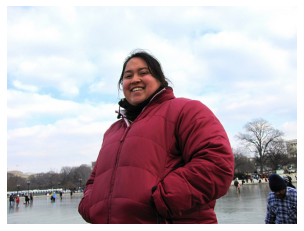

True captions:  [['girl', 'in', 'red', 'jacket', 'surrounded', 'by', 'people'], ['woman', 'in', 'puffy', 'red', 'jacket', 'poses', 'for', 'picture', 'at', 'an', 'ice', 'skating', 'rink'], ['woman', 'in', 'red', 'coat', 'is', 'smiling', 'while', 'people', 'in', 'the', 'background', 'are', 'walking', 'around', 'in', 'winter', 'clothing'], ['woman', 'wearing', 'red', 'coat', 'smiles', 'down', 'at', 'the', 'camera'], ['the', 'woman', 'in', 'red', 'jacket', 'is', 'smiling', 'at', 'the', 'camera']]
Predict caption:  ['man', 'is', 'sitting', 'on', 'rock', 'looking', 'at', 'the', 'camera']
sentence_bleus  [0, 0.35894549221513994, 0.24143224771822752, 0.45931768015663327, 0.4324232294480719]
bleu_sent1  0.7129629629629629
bleu_sent2  0.5126430789381373
bleu_sent3  0.5317720993254876
bleu_sent4  0.4832412046751586


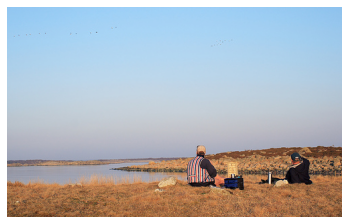

True captions:  [['two', 'men', 'sitting', 'on', 'the', 'bank', 'of', 'lake', 'with', 'an', 'ice', 'chest'], ['two', 'people', 'having', 'picnic', 'by', 'lake'], ['two', 'people', 'having', 'picnic', 'by', 'the', 'shore'], ['two', 'people', 'sitting', 'on', 'grass', 'in', 'front', 'of', 'lake', 'looking', 'at', 'the', 'sky'], ['two', 'people', 'with', 'hats', 'looking', 'at', 'lake', 'while', 'sitting', 'on', 'yellowgrassed', 'hill']]
Predict caption:  ['man', 'in', 'black', 'shirt', 'is', 'sitting', 'on', 'rock', 'near', 'the', 'water']
sentence_bleus  [0.3993476175412679, 0, 0.44670676422508115, 0.3812457747840318, 0.38047715792669323]
bleu_sent1  0.5561613453719235
bleu_sent2  0.44369911267818035
bleu_sent3  0.47880382992381676
bleu_sent4  0.4175287216248106


In [50]:
bleu_caption(3,model_xception, dataset_images,model_2_xception, shape_xception, preprocess_input_xception, max_length)

In [59]:
#bleu_caption(3,model_vgg16, dataset_images,model_2_vgg16, shape_vgg16, preprocess_input_vgg16, 32)

# BLEU for whole picture

In [52]:
def evaluate_model_bleu(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = [], []
    n = 0
    sentence_bleu1 = 0
    sentence_bleu2 = 0
    sentence_bleu3 = 0
    sentence_bleu4 = 0
    smooth = SmoothingFunction()
    for key, desc_list in descriptions.items():
        caption = generate_desc(model, tokenizer, photos[key], max_length)
        caption = caption.split(' ') 
        #references = [d.split() for d in desc_list]
        references = [d for d in desc_list]
        #actual.append(references)
        #predicted.append(yhat.split())
        n+=1
        score1 = sentence_bleu(references,caption,weights=(1.0,0,0,0),smoothing_function=smooth.method7)
        score2 = sentence_bleu(references,caption,weights=(0.5,0.5,0,0),smoothing_function=smooth.method7)
        score3 = sentence_bleu(references,caption,weights=(0.3,0.3,0.3,0),smoothing_function=smooth.method7)
        score4 = sentence_bleu(references,caption,weights=(0.25,0.25,0.25,0.25),smoothing_function=smooth.method7)
        
               
        
        sentence_bleu1 = sentence_bleu1 + float(score1)
        sentence_bleu2 = sentence_bleu2 + float(score2)
        sentence_bleu3 = sentence_bleu3 + float(score3)
        sentence_bleu4 = sentence_bleu4 + float(score4)
        
        actual.append(references)
        predicted.append(caption)
        
    asb1 = sentence_bleu1/n
    asb2 = sentence_bleu2/n
    asb3 = sentence_bleu3/n
    asb4 = sentence_bleu4/n
    
    cb1 = corpus_bleu(actual,predicted,weights=(1.0,0,0,0),smoothing_function=smooth.method7)
    cb2 = corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0),smoothing_function=smooth.method7)
    cb3 = corpus_bleu(actual,predicted,weights=(0.3,0.3,0.3,0),smoothing_function=smooth.method7)
    cb4 = corpus_bleu(actual,predicted,weights=(0.25,0.25,0.25,0.25),smoothing_function=smooth.method7)
    
    res = []
    res = [asb1,asb2,asb3,asb4,cb1,cb2,cb3,cb4]
    
    return res
    #print('Average_sentence_BLEU-1: ',sentence_bleu1/n)
    #print('Average_sentence_BLEU-2: ',sentence_bleu2/n)
    #print('Average_sentence_BLEU-3: ',sentence_bleu3/n)
    #print('Average_sentence_BLEU-4: ',sentence_bleu4/n)
    #print()
    #print('Corpus_BLEU-1: ',corpus_bleu(actual,predicted,weights=(1.0,0,0,0),smoothing_function=smooth.method7))
    #print('Corpus_BLEU-2: ',corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0),smoothing_function=smooth.method7))
    #print('Corpus_BLEU-3: ',corpus_bleu(actual,predicted,weights=(0.3,0.3,0.3,0),smoothing_function=smooth.method7))
    #print('Corpus_BLEU-4: ',corpus_bleu(actual,predicted,weights=(0.25,0.25,0.25,0.25),smoothing_function=smooth.method7))
    

In [53]:
bleu_xception = evaluate_model_bleu(model_xception, test_descriptions, test_features_xception, tokenizer, max_length)
bleu_inceptionV3 = evaluate_model_bleu(model_inceptionV3, test_descriptions, test_features_inceptionV3, tokenizer, max_length)
bleu_resnet50 = evaluate_model_bleu(model_resnet50, test_descriptions, test_features_resnet50, tokenizer, max_length)
bleu_mobilenet = evaluate_model_bleu(model_mobilenet, test_descriptions, test_features_mobilenet, tokenizer, max_length)
#bleu_vgg16 = evaluate_model_bleu(model_vgg16, test_descriptions, test_features_vgg16, tokenizer, 32)

In [57]:
bleu_table=pd.DataFrame()
bleu_table['bleu']=['Average_sentence_BLEU-1','Average_sentence_BLEU-2','Average_sentence_BLEU-3','Average_sentence_BLEU-4',
                   'Corpus_BLEU-1','Corpus_BLEU-2','Corpus_BLEU-3','Corpus_BLEU-4']
bleu_table['xception']=bleu_xception
bleu_table['inceptionV3']=bleu_inceptionV3
bleu_table['resnet50']=bleu_resnet50
bleu_table['mobilenet']=bleu_mobilenet
#bleu_table['vgg16']=bleu_vgg16

In [58]:
bleu_table

,bleu,xception,inceptionV3,resnet50,mobilenet
0,Average_sentence_BLEU-1,0.701975,0.674630,0.715580,0.705852
1,Average_sentence_BLEU-2,0.623396,0.614436,0.629171,0.620868
2,Average_sentence_BLEU-3,0.683525,0.680902,0.681583,0.674309
3,Average_sentence_BLEU-4,0.651981,0.657782,0.640852,0.633404
4,Corpus_BLEU-1,0.654244,0.633925,0.665356,0.663018
5,Corpus_BLEU-2,0.419746,0.406064,0.429224,0.424523
6,Corpus_BLEU-3,0.300206,0.293165,0.309311,0.303498
7,Corpus_BLEU-4,0.160611,0.157839,0.167933,0.163062
